This is a binary classification problem, since we're predicting if the patient develops Sepssis or not.

# Exploratory Data Analysis


In [47]:
#importing required libraries

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

data = pd.read_csv('./Paitients_Files_Train.csv')
data.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


Now that the data is loaded, all columns can be seen. ID and Insurance are variables that don't have a direct health impact on a patient, and hence can be removed. Let's describe the data next.

In [48]:
data.describe()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.686144
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.464447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,1.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In this description we can see important statistics about each numerical variable in the data including the mean and the standard deviation. Next let's find out how many unique values each variable has.

In [49]:
# How many unique values does a column have
data.nunique()

ID           599
PRG           17
PL           129
PR            44
SK            51
TS           164
M11          233
BD2          437
Age           50
Insurance      2
Sepssis        2
dtype: int64

We can see that some variables take more unique values than others. It's also nice to note that we don't have any categorical variables (including sepssis, which is a essentially binary variable).

Now I'll check if the data contains any null values

In [50]:
data.isnull().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

There are no null values in the dataset; which is good. However, I did notice a few values that were zero. This might actually represent a null value that was substituted with zero. It would be interesting to eventually develop a separate model which treats these values as null and compare the results. I have, however, not done that for this assignment.

# Data preparation
Now I'll remove the Insurance and ID fields from the data as they don't affect the Sepssis prediction.

In [51]:
patients_raw = data.drop(['Insurance', 'ID'], axis = 1)

patients_raw.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148,72,35,0,33.6,0.627,50,Positive
1,1,85,66,29,0,26.6,0.351,31,Negative
2,8,183,64,0,0,23.3,0.672,32,Positive
3,1,89,66,23,94,28.1,0.167,21,Negative
4,0,137,40,35,168,43.1,2.288,33,Positive


# Relationship analysis

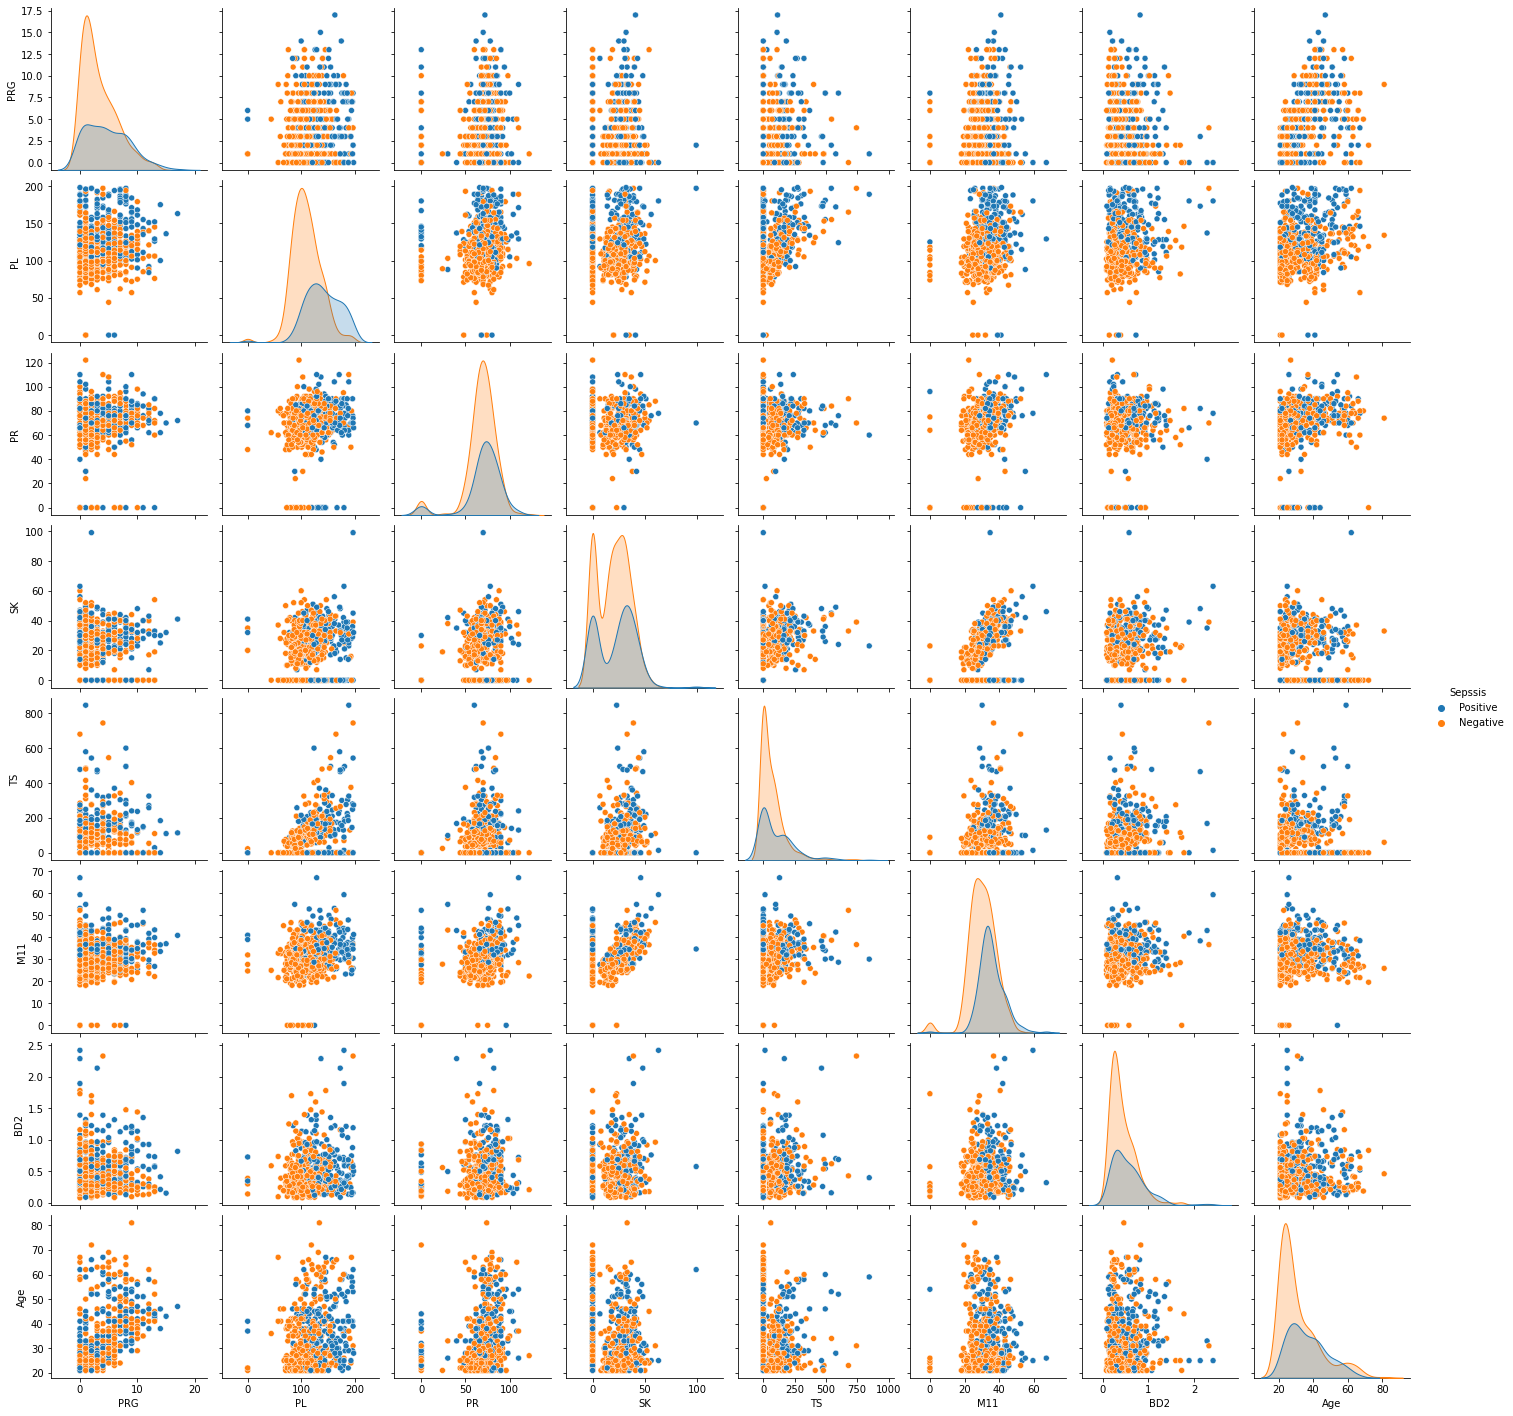

In [52]:
sns.pairplot(patients_raw, hue='Sepssis')

These pairplots show how each of the variables exist in relation to the other variables, with the hue being the Sepssis status of the patient.

This is very informative as we can see some variables have a higher correlation with one another, as well as a visible's tendency to impact the Sepssis status of the patient.

Next, let's find out the distribution of our "y" or dependent variable.

<AxesSubplot:xlabel='Sepssis', ylabel='count'>

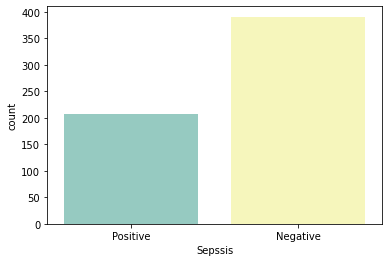

In [53]:
sns.countplot(x = 'Sepssis', data = patients_raw, palette = 'Set3')

We can see with this that most of the patients do not develop Sepssis in the ICU.

Next, I'll convert all categorical variables a numerical value.

In [54]:
patient_features = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Sepssis']

#replace Sepssis column with a binary numeric value

patients = patients_raw.copy(deep=True)
with pd.option_context('mode.chained_assignment', None):
	patients['Sepssis'][patients['Sepssis'] == 'Positive'] = 1
	patients['Sepssis'][patients['Sepssis'] == 'Negative'] = 0

patients.head(5)

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<AxesSubplot:>

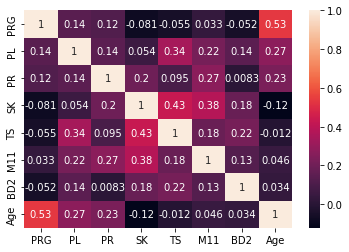

In [55]:
correlation = patients_raw.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

This heatmap is very telling as we can see that PRG has a high correlation with age.

Also, PR has a correlation with M11.

And SK has a high correlation with TS and M11

And TS has a correlation with BD2

# Model selection

In light of the exploratory data analysis, I decided to build a logistic regression model. This is because all the independent variables in the dataset are numeric, and logistic regression works well with such datasets.

Looking at the pair plot, important variables, while not exactly linearly separable, are roughly linearly separable. Using hyper parameter tuning and weighted classes, I hypothesize that a logistic regression model will work well.

While a decision tree or a Random Forest implementation of multiple decision trees might also have been a good choice, I propose that a logistic regression model with weighted classes will be a good choice in this case.

# Building the model
First, I split the data into a training and validation set with 20% of the data kept for validation, and 80% for training the model.

In [56]:
with pd.option_context('mode.chained_assignment', None):
    train_data, val_data = train_test_split(patients, test_size=0.2, shuffle=True, random_state=0)

In [57]:
train_x = train_data.drop(['Sepssis',], axis=1).to_numpy()
train_y = train_data[['Sepssis']].to_numpy().astype('int')

val_x = val_data.drop(['Sepssis',], axis=1).to_numpy()
val_y = val_data[['Sepssis']].to_numpy().astype('int')

# Evaluation framework

Let's set up an evaluation framework to test how good our model is

### Accuracy scores

In [58]:
classifier = LogisticRegression(random_state=0, solver='liblinear', max_iter=1000)
classifier.fit(train_x, train_y.ravel())

# print_accuracy_scores(classifier, train_x, train_y, val_x, val_y)
y_pred = classifier.predict(train_x)
val_pred = classifier.predict(val_x)

# used later for the log loss function
predicted_probabilities_train = classifier.predict_proba(train_x)
predicted_probabilities_val = classifier.predict_proba(val_x)

train_accuracy = metrics.accuracy_score(train_y, y_pred)
val_accuracy = metrics.accuracy_score(val_y, val_pred)

print("Train Accuracy score: {:.3f}".format(train_accuracy))
print("Validation Accuracy score: {:.3f}".format(val_accuracy))
print(metrics.classification_report(train_y, y_pred))

Train Accuracy score: 0.785
Validation Accuracy score: 0.758
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       316
           1       0.76      0.53      0.63       163

    accuracy                           0.78       479
   macro avg       0.78      0.72      0.74       479
weighted avg       0.78      0.78      0.77       479



### Confusion matrix function

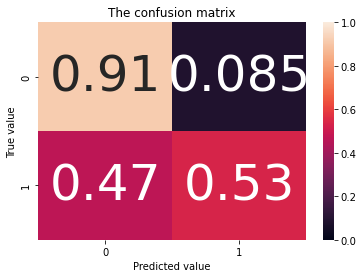

In [59]:
# Confusion matrix for

def show_confusion_matrix(cm, classes=None, title='The confusion matrix'):
	if classes is not None:
		sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmax=1., vmin=0., annot=True, annot_kws={'size': 50})
	else:
		sns.heatmap(cm, vmin=0., vmax=1.)

	plt.title(title)
	plt.ylabel('True value')
	plt.xlabel('Predicted value')


#Visualize the matrix

cm = metrics.confusion_matrix(train_y, y_pred)
cm_normalized = cm / cm.sum(axis=1).reshape(-1, 1)

show_confusion_matrix(cm_normalized, classes=classifier.classes_)

This shows us that we're doing a good job of predicting 

### Logarithmic loss function

In [60]:
#Log loss function
print("The log loss on the training data: ", metrics.log_loss(train_y, predicted_probabilities_train))
print("The log loss on the validation data: ", metrics.log_loss(val_y, predicted_probabilities_val))


The log loss on the training data:  0.49166759576449753
The log loss on the validation data:  0.48958925458712105


# Hyper parameter tuning

To tune the C value for this model, I lloop through all possible values it can take and run the classifier using that value, following which I store its accuracy score and logg loss function in an array.

In [61]:
C_List = np.geomspace(1e-5, 1e5, num=20)
classification_accuracy = []

Logarithmic_Loss = []

for c in C_List:
	classifier2 = LogisticRegression(random_state=0, solver='liblinear', max_iter=1000, C=c)
	classifier2.fit(train_x, train_y.ravel())
	score = classifier2.score(val_x, val_y)
	classification_accuracy.append(score)
	Logarithmic_Loss2 = metrics.log_loss(val_y, predicted_probabilities_val)
	Logarithmic_Loss.append(Logarithmic_Loss2)

Now I'll convert the array into a dataframe

In [64]:
classification_accuracy_np = np.array(classification_accuracy).reshape(20,)
Logarithmic_Loss_np = np.array(Logarithmic_Loss).reshape(20,)

#zip

outcomes = zip(C_List, classification_accuracy_np, Logarithmic_Loss_np)

#dataframe

outcomes_dataframe = pd.DataFrame(outcomes, columns=['C_List', 'classification_accuracy_np', 'Logarithmic_Loss_np'])
# outcomes_dataframe.sort_values('Logarithmic_Loss_np', ascending=True).reset_index()
outcomes_dataframe

,C_List,classification_accuracy_np,Logarithmic_Loss_np
0,0.000010,0.641667,0.489589
1,0.000034,0.658333,0.489589
2,0.000113,0.675000,0.489589
3,0.000379,0.708333,0.489589
4,0.001274,0.708333,0.489589
5,0.004281,0.700000,0.489589
6,0.014384,0.716667,0.489589
7,0.048329,0.708333,0.489589
8,0.162378,0.708333,0.489589
9,0.545559,0.750000,0.489589


# Testing the model on unseen data

In [63]:
data_unseen = pd.read_csv('./Paitients_Files_Test.csv')
data_unseen.shape

(169, 10)